# makemore, but made with an MLP (Multi-Layer Perceptron)


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    torch.set_default_device(mps_device)

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]  # show first 8 words

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)  # how many words do we have?

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))  # unique characters in the words
stoi = {s: i + 1 for i, s in enumerate(chars)}  # string to integer mapping
stoi["."] = 0  # add a special end-of-word character
itos = {i: s for s, i in stoi.items()}  # integer to string mapping
vocab_size = len(itos)  # size of the vocabulary
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Buiding the dataset


In [5]:
# Building the dataset
block_size = (
    5  # Context length: how many characters do we take to predict the next character?
)

def build_dataset(words):
    # The block size determines how many previous characters we consider to predict the next character.
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)  # for reproducibility
random.shuffle(words)  # shuffle the words to ensure randomness
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words))  # 10% for validation

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [6]:
# MLP Improvements
n_embd = 16 # The dimensionality of the character embedding vectors
n_hidden = 256 # The number of neurons in the hidden layer of the MLP

g = torch.Generator(device=mps_device).manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g, device=mps_device)  # character embeddings

# Essentially what we are doing by multiplying by small values is to keep the initial activations small, reducing the standard deviations.
# The right factor would be std = gain / fan_in ** 0.5

# ideal gain for tanh is 5/3
# fan_in = n_embd * block_size (for w1)
std_w1 = (5/3) / ((n_embd * block_size) ** 0.5)
print(std_w1)  # print the standard deviation for the first layer weights
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=mps_device) * std_w1 # first layer weights
# b1 = torch.randn((n_hidden,), generator=g) * 0.01 # first layer bias

# We know, intially, there is equal probability for each character, so the loss in the beginning should be -(log(1/num_classes))
# print(-torch.tensor(1/27.0).log())
# When the network is initialized, we want the logits to be roughly zero / equal, so the network isn't confidently predicting incorrect classes at the beginning of training.

W2 = torch.randn((n_hidden, vocab_size), generator=g, device=mps_device) * 0.01  # second layer weights
b2 = torch.randn((vocab_size,), generator=g, device=mps_device) * 0.01 # second layer bias

bn_gain = torch.ones((1, n_hidden), device=mps_device)
bn_bias = torch.zeros((1, n_hidden), device=mps_device)

bn_mean_running = torch.zeros((1, n_hidden), device=mps_device)
bn_std_running = torch.ones((1, n_hidden), device=mps_device)

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.numel() for p in parameters)) # total number of parameters

for p in parameters:
    p.requires_grad = True  # enable gradients for all parameters

0.18633899812498247
28363


Step:  0  LR:  0.1  Loss:  3.2969086170196533
Step:  10000  LR:  0.09000000000000001  Loss:  2.0444650650024414
Step:  20000  LR:  0.08100000000000002  Loss:  1.952597975730896
Step:  30000  LR:  0.07290000000000002  Loss:  1.9965250492095947
Step:  40000  LR:  0.06561000000000002  Loss:  1.8713178634643555
Step:  50000  LR:  0.05904900000000002  Loss:  1.9179959297180176
Step:  60000  LR:  0.05314410000000002  Loss:  1.8722679615020752
Step:  70000  LR:  0.04782969000000002  Loss:  1.9224727153778076
Step:  80000  LR:  0.043046721000000024  Loss:  1.8840751647949219
Step:  90000  LR:  0.03874204890000002  Loss:  1.8886542320251465
Step:  100000  LR:  0.03486784401000002  Loss:  1.7895841598510742
Step:  110000  LR:  0.03138105960900001  Loss:  1.7749958038330078
Step:  120000  LR:  0.028242953648100012  Loss:  1.7829409837722778
Step:  130000  LR:  0.025418658283290013  Loss:  1.7927660942077637
Step:  140000  LR:  0.022876792454961013  Loss:  1.8178280591964722
Step:  150000  LR:  0.

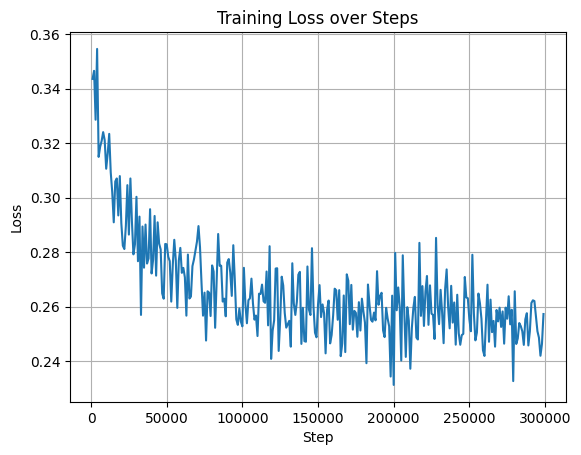

In [7]:
batch_size = 1024  # size of the mini-batch
max_steps = 300000
lossi = []
stepi = []
lr = 0.1 / 0.9

for i in range(max_steps):
    # Construct Mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g, device=mps_device)  # random indices for the mini-batch
    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb]  # get embeddings for the input characters
    embcat = emb.view(emb.shape[0], -1) # Concatenate embeddings
    hpreact = embcat @ W1 # + b1 # Hidden layer pre-activation
    
    bn_mean_i = hpreact.mean(dim=0, keepdim=True)
    bn_std_i = hpreact.std(dim=0, keepdim=True)

    hpreact = bn_gain * ((hpreact - bn_mean_i) / bn_std_i)  + bn_bias # Batch normalization

    with torch.no_grad():
        bn_mean_running = 0.99 * bn_mean_running + 0.01 * bn_mean_i
        bn_std_running = 0.99 * bn_std_running + 0.01 * bn_std_i

    h = torch.tanh(hpreact)  # apply activation
    logits = h @ W2 + b2  # compute logits for the output layer
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None  # zero out gradients

    loss.backward()  # compute gradients
    # Update parameters
    # lr = lrs[i]
    
    for p in parameters:
        p.data += -lr * p.grad  # update parameters using gradient descent

    # Track stats
    # lri.append(lre[i].cpu())
    if i % 1000 == 0 and i != 0:
        lossi.append(loss.log10().item())
        stepi.append(i)
    
    if i % 10000 == 0:
        lr *= 0.9
        print("Step: ", i, " LR: ", lr, " Loss: ", loss.item())
    
    # break

print("Final Loss: ", loss.item())  # print the loss value

# plt.plot(lri, lossi)
plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid()
plt.show()

In [8]:
# Calibrate the batch normalization statistics

# with torch.no_grad():
#     # pass the training data through the network
#     emb = C[X_train]  # get embeddings for the input characters
#     embcat = emb.view(emb.shape[0], -1)  # concatenate embeddings
#     hpreact = embcat @ W1 + b1

#     # measure the batch normalization statistics over the entire training set
#     bn_mean = hpreact.mean(dim=0, keepdim=True)
#     bn_std = hpreact.std(dim=0, keepdim=True)


In [9]:
# plt.figure(figsize=(16,32))
# plt.imshow(h.abs().detach().cpu().numpy() > 0.99, cmap='gray', interpolation='nearest')

In [10]:
# plt.hist(h.view(-1).detach().cpu().numpy(), bins=50);

In [11]:
# plt.hist(hpreact.view(-1).detach().cpu().numpy(), bins=50);

## Split Loss Calculation

In [12]:
@torch.no_grad()  # disable gradient tracking for evaluation
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]  # get embeddings for the input characters
    embcat = emb.view(emb.shape[0], -1)  # concatenate embeddings

    hpreact = embcat @ W1 # + b1 # Hidden layer pre-activation
    # hpreact_mean = hpreact.mean(dim=0, keepdim=True)
    # hpreact_std = hpreact.std(dim=0, keepdim=True)
    hpreact = bn_gain * ((hpreact - bn_mean_running) / bn_std_running)  + bn_bias # Batch normalization
    h = torch.tanh(hpreact)  # apply activation
    logits = h @ W2 + b2  # compute logits for the output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.7946401834487915
val 2.0615358352661133
test 2.0526907444000244


### Training the model on the entirety of the data for all passes will lead to a very large training time, so we will use batches of data for training

It is generally better to train smaller batches of data though the gradient is not as accurate, but its better to take many small steps than a few large steps.
### Training split, dev/validation split, test split
### 80%. 10%, 10% split


Since the training and dev set lossi are very similar, we can assume that the model is not overfitting and is generalizing well to the dev set.
This model is not powerful enough to learn the patterns in the data/purely memorizing the data, so we can safely increase the size of the model by increasing the number of hidden units in the first layer, or by adding more layers to the model to improve the performance of the model.

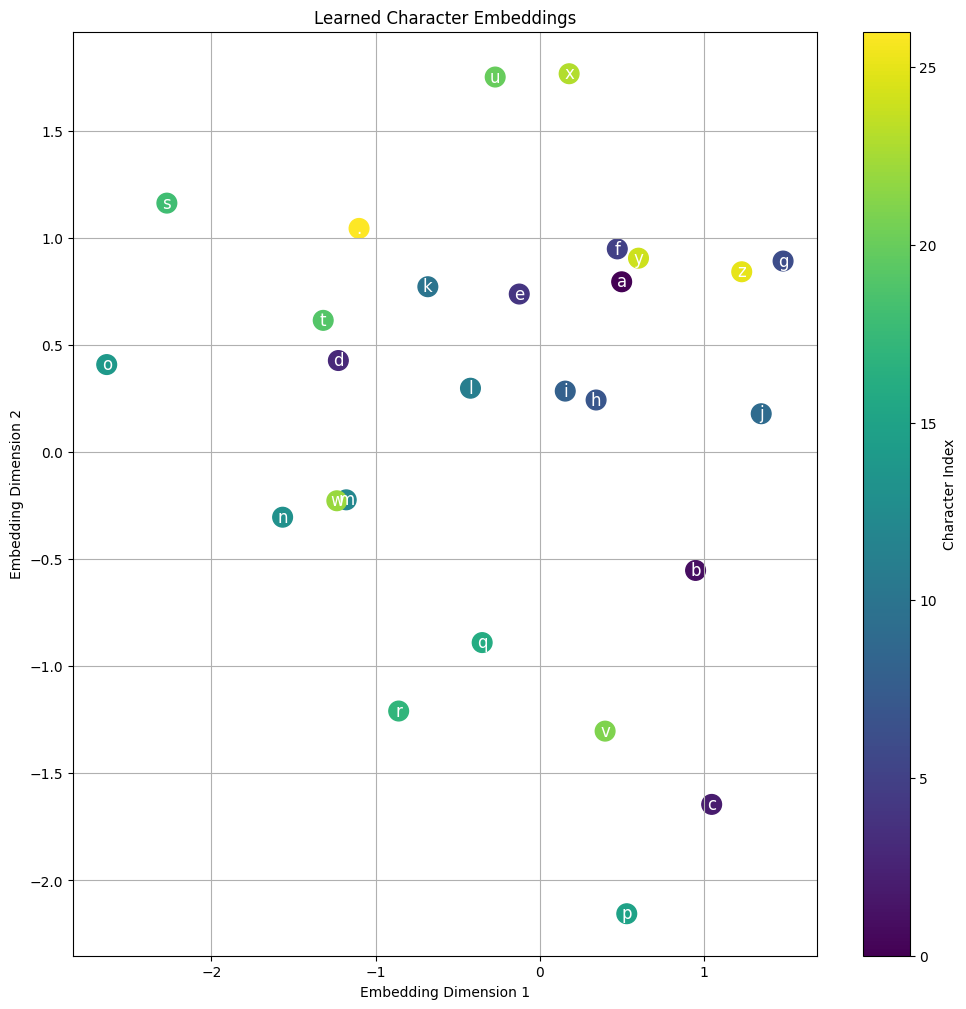

In [13]:
# # Visualise the learned embeddings
plt.figure(figsize=(12, 12))
plt.scatter(
    C[:, 0].detach().cpu().numpy(),
    C[:, 1].detach().cpu().numpy(),
    s=200,
    c=range(len(C)),
    cmap='viridis',
)
for i, ch in enumerate(itos.values()):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        ch,
        fontsize=12,
        ha='center',
        va='center',
        color='white',
    )
plt.title("Learned Character Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.colorbar(label='Character Index')
plt.grid()
plt.show()


In [14]:
# Sample from the model
g = torch.Generator(device=mps_device).manual_seed(2147483647 + 10)  # set random seed

for _ in range(25):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context, device=mps_device)]  # get embeddings for the context
        
        embcat = emb.view(1, -1)  # concatenate embeddings

        hpreact = embcat @ W1
        hpreact = bn_gain * ((hpreact - bn_mean_running) / bn_std_running)  + bn_bias # Batch normalization
        h = torch.tanh(hpreact)  # apply activation
        logits = h @ W2 + b2  # compute logits for the output layer

        prob = F.softmax(logits, dim=-1)

        ix = torch.multinomial(prob, num_samples=1, generator=g).item()  # sample from the distribution
        context = context[1:] + [ix]  # slide the window, add new character
        out.append(ix)
        if ix == 0:  # end of word character
            break
        
    print(''.join(itos[i] for i in out))

giarton.
kaileez.
alysson.
marik.
zarphowaer.
iziaey.
xya.
inel.
calea.
lilyya.
rya.
matvis.
kacey.
apent.
aleen.
arag.
her.
husey.
khyla.
lochlani.
mariana.
keana.
mikenzee.
pagnavin.
davyana.
